In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Stations = pd.read_csv('hubway_stations.csv')

In [3]:
Stations.head()

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing


In [4]:
Trips = pd.read_csv('hubway_trips.csv')

In [5]:
Trips.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female


In [6]:
Trips.dtypes

seq_id          int64
hubway_id       int64
status         object
duration        int64
start_date     object
strt_statn    float64
end_date       object
end_statn     float64
bike_nr        object
subsc_type     object
zip_code       object
birth_date    float64
gender         object
dtype: object

In [6]:
registered_members_duration = np.array(Trips['duration'].loc[Trips['subsc_type'] == 'Registered'])

In [7]:
registered_members_duration

array([  9, 220,  56, ..., 480, 120, 420], dtype=int64)

In [8]:
casual_members_duration = np.array(Trips['duration'].loc[Trips['subsc_type'] == 'Casual'])

In [9]:
casual_members_duration

array([ 994, 2121, 1315, ...,  780,  300,  540], dtype=int64)

In [10]:
np.mean(registered_members_duration)

733.3289835450383

In [11]:
np.mean(casual_members_duration)

2293.4422135752234

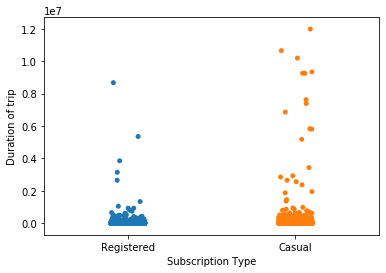

In [12]:
sns.stripplot(x='subsc_type',y='duration', data=Trips)
plt.ylabel('Duration of trip')
plt.xlabel('Subscription Type')
plt.show()

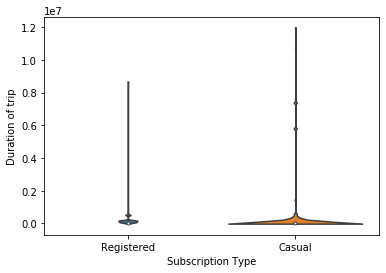

In [13]:
sns.violinplot(x='subsc_type',y='duration', data=Trips)
plt.ylabel('Duration of trip')
plt.xlabel('Subscription Type')
plt.show()

With this we can conclude that Casual members tend to have (on average) longer trips than Registered members.

Registered trip mean (seconds): 733.3289835450383

Casual trip mean (seconds): 2293.4422135752234

In [14]:
Trips.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female


In [15]:
Trips.dtypes

seq_id          int64
hubway_id       int64
status         object
duration        int64
start_date     object
strt_statn    float64
end_date       object
end_statn     float64
bike_nr        object
subsc_type     object
zip_code       object
birth_date    float64
gender         object
dtype: object

In [14]:
Trips['start_date'] = pd.to_datetime(Trips['start_date'], format='%m/%d/%Y %H:%M:%S')

In [18]:
Trips.dtypes

seq_id                 int64
hubway_id              int64
status                object
duration               int64
start_date    datetime64[ns]
strt_statn           float64
end_date              object
end_statn            float64
bike_nr               object
subsc_type            object
zip_code              object
birth_date           float64
gender                object
dtype: object